# Research Request - Non-Revenue Vehicle Fleet Sizes #1236

How many non-revenue vehicles do transit agencies have. 

Also known as "service vehicles", Non-revenue vehicle data are excluded from UPT, VRM, VRH reports (since these NRV are not meant to carry passengers or make revenue).

NRVs are like support vehicles used to maintain transit operations (service/maintenance vehicles, other support.

Service Vehicle Inventory (Form A-35): "Transit agencies are required to report data on service vehicles, or vehicles which do not carry passengers.


In [1]:
import requests
import json
import pandas as pd
import numpy as np
import altair as alt
import seaborn as sns # for distplot

from calitp_data_analysis.tables import tbls
from siuba import _, filter, count, collect, show_query, select
from scipy.stats import zscore # find any outliers in the data 
from shared_utils import schedule_rt_utils

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)

GCS_PATH = "gs://calitp-analytics-data/data-analyses/ntd/"

# use `mart_ntd_annual_reporting.fct_vehicles_type_count_by_agency` to get service vehicles?

In [2]:
keep_cols=[
    "ntd_id",
    "agency",
    "city",
    "organization_type",
    "reporter_type",
    #"agency_voms",
    "total_revenue_vehicles",
    "total_service_vehicles"
]

ntd_service_veh = (
    tbls.mart_ntd_annual_reporting.fct_vehicles_type_count_by_agency()
    >> filter(
        _.state == 'CA',
        _.report_year == 2023
    )
    >> collect()
)[keep_cols].reset_index(drop=True)


In [3]:
ntd_service_veh.describe() # 0 revenue and service vehicles?

,total_revenue_vehicles,total_service_vehicles
count,225.000000,225.000000
mean,106.217778,23.680000
std,335.632827,119.112585
min,0.000000,0.000000
25%,7.000000,0.000000
50%,19.000000,0.000000
75%,60.000000,7.000000
max,4060.000000,1498.000000


In [4]:
keep_cols_2=[
    "ntd_id",
    "agency",
    "city",
    "organization_type",
    "reporter_type",
    "mode",
    "type_of_service",
    "unlinked_passenger_trips",
    "vehicle_revenue_hours",

]

ntd_ridership_metrics = (
    tbls.mart_ntd_annual_reporting.fct_metrics()
    >> filter(
        _.state == 'CA',
        _.report_year == 2023
    )
    >> collect()
)[keep_cols_2].reset_index(drop=True)

In [5]:
# aggregate UPT and VRM by agency

upt_by_agency = ntd_ridership_metrics.groupby(["ntd_id","agency"]).agg({
    "unlinked_passenger_trips":"sum",
    "vehicle_revenue_hours":"sum"
}).reset_index()

upt_by_agency.head()

,ntd_id,agency,unlinked_passenger_trips,vehicle_revenue_hours
0,90003,"San Francisco Bay Area Rapid Transit District, dba: SF BART",50764402.0,2724074.0
1,90004,Golden Empire Transit District,3293593.0,289338.0
2,90006,Santa Cruz Metropolitan Transit District,3350026.0,214748.0
3,90008,"City of Santa Monica, dba: Big Blue Bus",7767725.0,416944.0
4,90009,"San Mateo County Transit District, dba: SamTrans",8773845.0,651839.0


## pulling data from NTD `2023 Annual Database Service Vehicle Inventory` 

Revenue Vehicle Inventory: https://www.transit.dot.gov/ntd/data-product/2023-annual-database-revenue-vehicle-inventory
>Contains operating statistics reported by mode and type of service. Categorized by vehicles operated and vehicles available in maximum service by day and time period.

Service Vehilce Inventory: https://www.transit.dot.gov/ntd/data-product/2023-annual-database-service-vehicle-inventory

>Contains operating statistics reported by mode and type of service. Categorized by vehicles operated and vehicles available in maximum service by day and time period.

In [6]:
rev_url="https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Revenue%20Vehicle%20Inventory.xlsx"
serv_url= "https://www.transit.dot.gov/sites/fta.dot.gov/files/2024-10/2023%20Service%20Vehicle%20Inventory.xlsx"

ntd_rev_veh_inv = pd.read_excel(rev_url, engine="openpyxl")
ntd_serv_veh_inv = pd.read_excel(serv_url, engine='openpyxl')

ntd_rev_veh_inv["NTD ID"] = ntd_rev_veh_inv["NTD ID"].astype(str)
ntd_serv_veh_inv["NTD ID"] = ntd_serv_veh_inv["NTD ID"].astype(str)

display(
    ntd_rev_veh_inv.info(),
    ntd_serv_veh_inv.info()
)

# need to filter by CA agenicess

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34294 entries, 0 to 34293
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   State/Parent NTD ID                           13526 non-null  object 
 1   NTD ID                                        34294 non-null  object 
 2   Agency Name                                   34294 non-null  object 
 3   Reporter Type                                 34294 non-null  object 
 4   Reporting Module                              34294 non-null  object 
 5   Group Plan Sponsor NTDID                      18238 non-null  object 
 6   Group Plan Sponsor Name                       18238 non-null  object 
 7   Modes                                         34294 non-null  object 
 8   Revenue Vehicle Inventory ID                  34294 non-null  int64  
 9   Agency Fleet ID                               34294 non-null 

None

None

## what are the service vehicles in `service vehicle inventory`?

In [7]:
ntd_serv_veh_inv[
    [
        #"Primary Mode Served",
        "Vehicle Type",
    ]
].value_counts()

Vehicle Type                         
Trucks and other Rubber Tire Vehicles    13984
Automobiles                               2818
Steel Wheel Vehicles                       897
dtype: int64

In [8]:
#long list,
# mix of mfg name, specific model name, but also some random numbers.
# 

ntd_serv_veh_inv["Service Fleet Name"].value_counts().sample(20)


Ford/F250                                 1
Transit Cars 1100                         1
50891                                     1
FORD F450 CAB/CHASSIS                     4
NRV 129                                   1
1801                                      1
MaintART                                  1
TRAINING                                  1
2008, FREIGHTLINER, SPRINTER 3500 VAN     1
TRUCKOT-2022-DODGE-RAM-2500               1
Suretrac Utility                          1
2017FORD-T150                             2
1185                                      1
2016 Dodge Promaster                      1
Staff Vehcile                             1
2023FORD-EXPEDITION                       1
GMC C7H042                                1
905915                                    1
TGIV TRACK GEOMETRY INSPECTION VEHICLE    1
2018 Ford Fusion                          2
Name: Service Fleet Name, dtype: int64

## use `dim_annual_agency_information` to get ntd id in CA?
might not need this, can get ntd ID from dim_annual_service_agencies


In [9]:
keep_col_0 = [
    "ntd_id",
    "agency_name",
    "reporter_type",
    "city",
    "primary_uza_name"
]

agency_info=(
    tbls.mart_ntd.dim_annual_agency_information()
    >> filter(
        _.state == "CA",
        _.year == 2023,
        _._is_current == True
    )
    >> collect()
)#[keep_col_0]

#agency_info = agency_info[keep_col_0]

display(agency_info.info(), agency_info.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 48 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   key                              237 non-null    object             
 1   year                             237 non-null    int64              
 2   ntd_id                           237 non-null    object             
 3   state_parent_ntd_id              59 non-null     object             
 4   agency_name                      237 non-null    object             
 5   reporter_acronym                 142 non-null    object             
 6   doing_business_as                120 non-null    object             
 7   division_department              130 non-null    object             
 8   legacy_ntd_id                    152 non-null    object             
 9   reported_by_ntd_id               59 non-null     object             
 10  re

None

,key,year,ntd_id,state_parent_ntd_id,agency_name,reporter_acronym,doing_business_as,division_department,legacy_ntd_id,reported_by_ntd_id,reported_by_name,reporter_type,reporting_module,organization_type,subrecipient_type,fy_end_date,original_due_date,address_line_1,address_line_2,p_o__box,city,state,zip_code,zip_code_ext,region,url,fta_recipient_id,ueid,service_area_sq_miles,service_area_pop,primary_uza_code,primary_uza_name,tribal_area_name,population,density,sq_miles,voms_do,voms_pt,total_voms,volunteer_drivers,personal_vehicles,tam_tier,number_of_state_counties,number_of_counties_with_service,state_admin_funds_expended,_valid_from,_valid_to,_is_current
0,c2ca2b69c59b5249648128f17dc7566a,2023,90043,None,City of Commerce,CCT,City of Commerce Transit,Transportation,9043,None,None,Full Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,2535 Commerce Way,None,None,Commerce,CA,90040.0,1410.0,9.0,https://www.ci.commerce.ca.us/city-hall/transportation,1650.0,C1H2LGLYFD63,11.0,12997.0,None,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,14.0,NaN,14.0,NaN,NaN,Tier II,NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True
1,56674e402b54f109186d7c4a4b59f0c4,2023,90008,None,City of Santa Monica,BBB,Big Blue Bus,Department of Transportation,9008,None,None,Full Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,1685 Main St,None,None,Santa Monica,CA,90401.0,3248.0,9.0,http://www.bigbluebus.com/,1664.0,DEDCLBH5GBC3,69.0,1022273.0,None,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,124.0,19.0,143.0,NaN,NaN,Tier I (Fixed Route VOMS),NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True
2,55bfda29a4a916390c88d363559a71d8,2023,90201,None,City of Turlock,None,Turlock Transit,Transit,9201,None,None,Full Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,156 S Broadway,None,None,Turlock,CA,95380.0,5454.0,9.0,www.turlocktransit.com,2715.0,JDYXAB12QLG1,22.0,79203.0,None,"Turlock, CA",None,79203.0,4688.330579,16.89,NaN,12.0,12.0,NaN,NaN,Tier II,NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True
3,d4342f7c3020e383f3219174dbd60595,2023,90256,None,City of Burbank,None,None,Community Development-Transportation,None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,275 E Olive Ave,None,None,Burbank,CA,91502.0,1232.0,9.0,www.burbankbus.org,5566.0,N9Q5C7NS3JS5,17.0,107337.0,None,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,5.0,12.0,17.0,NaN,NaN,Tier II,NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True
4,ce9c6c0fbb6292bf2600098958c1833f,2023,90296,None,City of Claremont,None,None,Community Services/ Transit Services,9296,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,207 Harvard Ave,None,None,Claremont,CA,91711.0,4719.0,9.0,pvtrans.org,2271.0,DGVWH4PSMR98,13.0,36700.0,None,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,22.0,22.0,NaN,NaN,Tier II,NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True


In [10]:
len(agency_info["agency_name"].unique())

223

In [11]:
ca_ntd_id = agency_info["ntd_id"].unique().tolist()

len(ca_ntd_id)

237

In [12]:
agency_info.value_counts(subset=["agency_name","ntd_id"]) #why does Los Angeles County have multiple ntd id?

agency_name                                                      ntd_id
Access Services                                                  90157     1
Los Angeles County Metropolitan Transportation Authority         90154     1
Long Beach Transit                                               90023     1
Los Angeles County                                               90269     1
                                                                 90270     1
                                                                 90271     1
                                                                 90273     1
                                                                 90274     1
                                                                 90275     1
                                                                 90276     1
                                                                 90278     1
                                                                 90279     1
Los 

In [13]:
agency_info[agency_info["agency_name"]=="Los Angeles County"] #why does Los Angeles County have multiple ntd id?

,key,year,ntd_id,state_parent_ntd_id,agency_name,reporter_acronym,doing_business_as,division_department,legacy_ntd_id,reported_by_ntd_id,reported_by_name,reporter_type,reporting_module,organization_type,subrecipient_type,fy_end_date,original_due_date,address_line_1,address_line_2,p_o__box,city,state,zip_code,zip_code_ext,region,url,fta_recipient_id,ueid,service_area_sq_miles,service_area_pop,primary_uza_code,primary_uza_name,tribal_area_name,population,density,sq_miles,voms_do,voms_pt,total_voms,volunteer_drivers,personal_vehicles,tam_tier,number_of_state_counties,number_of_counties_with_service,state_admin_funds_expended,_valid_from,_valid_to,_is_current
24,2c0bb79b7b0e76fb6cd2876bd1df031d,2023,90273,None,Los Angeles County,LACDPW,None,"Department of Public Works, Transit Operations - Florence Firestone",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,1331.0,9.0,https://www.dpw.lacounty.gov/landing/transportation.cfm,5566.0,None,7.0,63387.0,None,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,2.0,2.0,NaN,NaN,Tier II,NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True
29,2d73d888530862c1a7aa70cab045c575,2023,90276,None,Los Angeles County,LACDPW,None,"Department of Public Works, Transit Operations - South Whittier",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,1331.0,9.0,https://www.dpw.lacounty.gov/landing/transportation.cfm,5566.0,None,5.0,86883.0,None,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,5.0,5.0,NaN,NaN,Tier II,NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True
76,0ad21d98d72decda036697dee2a39b9b,2023,90275,None,Los Angeles County,None,None,"Department of Public Works, Transit Operations, Lennox MB",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,1331.0,9.0,www.lagobus.info,5566.0,ZLJUW5L9K685,16.0,27897.0,None,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,1.0,1.0,NaN,NaN,Tier II,NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True
87,63aa9ab7eed8d23b41d53975670def51,2023,90269,None,Los Angeles County,None,LA County Public Works,"Department of Public Works, Transit Operations, Athens MB",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,1331.0,9.0,www.lagobus.info,5566.0,ZLJUW5L9K685,25.0,23159.0,None,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,2.0,2.0,NaN,NaN,Tier II,NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True
106,dfd1d3a27488c76e37af6e8560dc8cc6,2023,90270,None,Los Angeles County,LACDPW,None,"Department of Public Works, Transit Operations – Avocado Heights",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200000,1698710400000,900 S Fremont Ave,None,None,Alhambra,CA,91803.0,None,9.0,https://www.dpw.lacounty.gov/landing/transportation.cfm,5566.0,None,9.0,15500.0,None,"Los Angeles--Long Beach--Anaheim, CA",None,12237376.0,7476.284117,1636.83,NaN,1.0,1.0,NaN,NaN,Tier II,NaN,NaN,NaN,2024-11-27 20:30:23.391972+00:00,2098-12-31 23:59:59.999999+00:00,True
112,85ea5ddb2ea2dadf51acb0eb1d746bfa,2023,90279,None,Los Angeles County,None,None,"Department of Public Works, Transit Operations, Willowbrook et. al. DR",None,None,None,Reduced Reporter,Urban,"City, County or Local Government Unit or Department of Transportation",None,1688083200

In [14]:
## filter rev and service list by ca ntd id
ca_rev_veh_inv = ntd_rev_veh_inv[ntd_rev_veh_inv["NTD ID"].isin(ca_ntd_id)]
ca_serv_veh_inv = ntd_serv_veh_inv[ntd_serv_veh_inv["NTD ID"].isin(ca_ntd_id)]

display(
    len(ntd_rev_veh_inv),
    len(ca_rev_veh_inv),
    len(ntd_serv_veh_inv),
    len(ca_serv_veh_inv),
)
#ntd_srv_veh_inv


34294

3420

17699

2744

## use `dim_annual_service_agencies` ntd_id, UPT, VRM, VRH for agencies?

How is this different from `dim_annual_agency_information`? are all reporter types included?

description:
>Provides transit agency-wide totals for service data for applicable agencies reporting to the National Transit Database. This view displays the data at a higher level (by agency), based on the "NTD Annual Data - Service (by Mode and Time Period)" dataset. In the years 2015-2021, you can find this data in the "Service" data table on NTD Program website, at https://transit.dot.gov/ntd/ntd-data. In versions of the data tables from before 2014, you can find data on service in the file called "Transit Operating Statistics: Service Supplied and Consumed."

In [15]:
keep_cols_annual_service=[
    "ntd_id",
    "agency",
    "reporter_type",
    "city",
    "primary_uza_name",
    "actual_vehicles_passenger_car_revenue_hours",
    "actual_vehicles_passenger_car_revenue_miles",
    "unlinked_passenger_trips_upt"
]

upt_vrm_vrh=(
    tbls.mart_ntd.dim_annual_service_agencies ()
    >> filter(
        _.state == "CA",
        _.report_year == 2023,

    )
    >> collect()
)[keep_cols_annual_service]

upt_vrm_vrh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   ntd_id                                       209 non-null    object 
 1   agency                                       209 non-null    object 
 2   reporter_type                                209 non-null    object 
 3   city                                         208 non-null    object 
 4   primary_uza_name                             165 non-null    object 
 5   actual_vehicles_passenger_car_revenue_hours  209 non-null    float64
 6   actual_vehicles_passenger_car_revenue_miles  209 non-null    float64
 7   unlinked_passenger_trips_upt                 209 non-null    float64
dtypes: float64(3), object(5)
memory usage: 13.2+ KB


In [16]:
col_check = ["reporter_type","agency"]

for i in col_check:
    display(upt_vrm_vrh[i].value_counts().head())
    
# LA county still showing multiple rows. so, consistent with `dim_annual_agency_information`

Reduced Reporter    84
Full Reporter       81
Rural Reporter      44
Name: reporter_type, dtype: int64

Los Angeles County                                10
Amador Transit                                     1
City of Glendale, dba: Beeline Bus/Dial-A-Ride     1
City of Santa Fe Springs                           1
City of South Gate                                 1
Name: agency, dtype: int64

In [17]:
# get unique NTD IDs from table
annual_service_ntd_id = upt_vrm_vrh["ntd_id"].unique().tolist()
type(annual_service_ntd_id)

list

In [18]:
## need to filter the rev and serv veh inv sheet by annual service ntd id, then join the upt_vrm_vrh data

# rev and serv veh inv
#ntd_rev_veh_inv
#ntd_srv_veh_inv

#metrics
#upt_vrm_vrh

#ntd ID
#annual_service_ntd_id


ca_rev_veh = ntd_rev_veh_inv[ntd_rev_veh_inv["NTD ID"].isin(annual_service_ntd_id)]

ca_serv_veh = ntd_serv_veh_inv[ntd_serv_veh_inv["NTD ID"].isin(annual_service_ntd_id)]


display(
    len(ca_rev_veh),
    len(ca_serv_veh)
)

3340

2741

In [19]:
upt_vrm_vrh.describe()

,actual_vehicles_passenger_car_revenue_hours,actual_vehicles_passenger_car_revenue_miles,unlinked_passenger_trips_upt
count,2.090000e+02,2.090000e+02,2.090000e+02
mean,1.974787e+05,3.017682e+06,3.997801e+06
std,7.133054e+05,1.065322e+07,2.235365e+07
min,1.290000e+02,2.764000e+03,2.390000e+02
25%,6.810000e+03,8.249300e+04,2.823200e+04
50%,2.407500e+04,3.464130e+05,1.255200e+05
75%,9.376300e+04,1.402852e+06,8.388670e+05
max,8.220160e+06,1.094675e+08,2.763024e+08


In [20]:
ca_serv_veh.describe()

,Fleet ID,Year of Manufacture,Number of Vehicles,Useful Life Benchmark,Percent Agency Capital Responsibility,Estimated Cost,Year Dollar of the Estimated Cost
count,2741.000000,2741.000000,2741.000000,2741.000000,2741.000000,2.741000e+03,2741.000000
mean,17057.534841,2012.197008,1.942357,11.449106,99.854068,1.552494e+05,2016.551623
std,10193.421770,8.749674,3.290602,5.341620,3.818015,5.934207e+05,6.517969
min,1.000000,1958.000000,0.000000,4.000000,0.000000,1.000000e+03,1973.000000
25%,8508.000000,2009.000000,1.000000,8.000000,100.000000,2.860500e+04,2014.000000
50%,16592.000000,2014.000000,1.000000,10.000000,100.000000,4.464017e+04,2018.000000
75%,25885.000000,2018.000000,1.000000,14.000000,100.000000,9.739100e+04,2021.000000
max,31904.000000,2023.000000,70.000000,43.000000,100.000000,1.417500e+07,2023.000000


In [21]:
# group by agency
test = ca_serv_veh.groupby(["NTD ID","Agency Name"]).agg({
    "NTD ID":"count",
    "Number of Vehicles":"sum"
}).reset_index(
    drop=True
)
test

,NTD ID,Number of Vehicles
0,177,660
1,10,26
2,28,41
3,20,20
4,27,78
5,9,25
6,40,40
7,156,356
8,52,154
9,544,544


## calculate service vehicle ratios


In [22]:
# join ntd_service_veh and upt_by_agency

service_veh_upt = ntd_service_veh.merge(upt_by_agency, on=["ntd_id","agency"], how="inner", indicator=True)
service_veh_upt.head()

,ntd_id,agency,city,organization_type,reporter_type,total_revenue_vehicles,total_service_vehicles,unlinked_passenger_trips,vehicle_revenue_hours,_merge
0,90003,"San Francisco Bay Area Rapid Transit District, dba: SF BART",Oakland,Independent Public Agency or Authority of Transit Service,Full Reporter,846.0,660.0,50764402.0,2724074.0,both
1,90004,Golden Empire Transit District,Bakersfield,Independent Public Agency or Authority of Transit Service,Full Reporter,137.0,26.0,3293593.0,289338.0,both
2,90006,Santa Cruz Metropolitan Transit District,Santa Cruz,Independent Public Agency or Authority of Transit Service,Full Reporter,125.0,41.0,3350026.0,214748.0,both
3,90008,"City of Santa Monica, dba: Big Blue Bus",Santa Monica,"City, County or Local Government Unit or Department of Transportation",Full Reporter,221.0,20.0,7767725.0,416944.0,both
4,90009,"San Mateo County Transit District, dba: SamTrans",San Carlos,Independent Public Agency or Authority of Transit Service,Full Reporter,434.0,78.0,8773845.0,651839.0,both


In [23]:
# identify zscores
z_score = service_veh_upt[[
    "vehicle_revenue_hours",
    "total_service_vehicles",
    "unlinked_passenger_trips"
]].apply(zscore)

In [24]:
# remove outliers
threshold = 3
service_v_upt_no_outliers = service_veh_upt[(z_score.abs() < threshold).all(axis=1)]


In [25]:
display(
    "initial data",
    service_veh_upt.describe(),
    "outliers removed",
    service_v_upt_no_outliers.describe()
)
# can see that the min/max values of each col were adjusted

'initial data'

,total_revenue_vehicles,total_service_vehicles,unlinked_passenger_trips,vehicle_revenue_hours
count,209.000000,209.000000,2.090000e+02,2.090000e+02
mean,113.411483,25.473684,3.997801e+06,1.974787e+05
std,347.217418,123.424808,2.235365e+07,7.133054e+05
min,1.000000,0.000000,2.390000e+02,1.290000e+02
25%,8.000000,0.000000,2.823200e+04,6.810000e+03
50%,20.000000,1.000000,1.255200e+05,2.407500e+04
75%,60.000000,8.000000,8.388670e+05,9.376300e+04
max,4060.000000,1498.000000,2.763024e+08,8.220160e+06


'outliers removed'

,total_revenue_vehicles,total_service_vehicles,unlinked_passenger_trips,vehicle_revenue_hours
count,205.000000,205.000000,2.050000e+02,2.050000e+02
mean,79.434146,12.682927,1.467486e+06,1.192848e+05
std,173.081761,38.042056,4.351655e+06,3.015260e+05
min,1.000000,0.000000,2.390000e+02,1.290000e+02
25%,8.000000,0.000000,2.792900e+04,6.590000e+03
50%,20.000000,1.000000,1.198630e+05,2.345900e+04
75%,60.000000,8.000000,7.392380e+05,8.936800e+04
max,1289.000000,356.000000,3.519006e+07,2.076903e+06


In [26]:
# calculate ratios

# service vehicles per ....(10,000 upt, 1,000 vrh)
multiplier= 10000

service_v_upt_no_outliers["srv_upt_ratio"] = (service_v_upt_no_outliers["total_service_vehicles"] / service_v_upt_no_outliers["unlinked_passenger_trips"])*multiplier

service_v_upt_no_outliers["srv_vrh_ratio"] = (service_v_upt_no_outliers["total_service_vehicles"] / service_v_upt_no_outliers["vehicle_revenue_hours"])*multiplier

service_v_upt_no_outliers.describe()

/tmp/ipykernel_507/856235202.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  service_v_upt_no_outliers["srv_upt_ratio"] = (service_v_upt_no_outliers["total_service_vehicles"] / service_v_upt_no_outliers["unlinked_passenger_trips"])*multiplier
/tmp/ipykernel_507/856235202.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  service_v_upt_no_outliers["srv_vrh_ratio"] = (service_v_upt_no_outliers["total_service_vehicles"] / service_v_upt_no_outliers["vehicle_revenue_hours"])*multiplier


,total_revenue_vehicles,total_service_vehicles,unlinked_passenger_trips,vehicle_revenue_hours,srv_upt_ratio,srv_vrh_ratio
count,205.000000,205.000000,2.050000e+02,2.050000e+02,205.000000,205.000000
mean,79.434146,12.682927,1.467486e+06,1.192848e+05,0.132259,0.852353
std,173.081761,38.042056,4.351655e+06,3.015260e+05,0.284223,1.474094
min,1.000000,0.000000,2.390000e+02,1.290000e+02,0.000000,0.000000
25%,8.000000,0.000000,2.792900e+04,6.590000e+03,0.000000,0.000000
50%,20.000000,1.000000,1.198630e+05,2.345900e+04,0.008735,0.088121
75%,60.000000,8.000000,7.392380e+05,8.936800e+04,0.135864,1.246118
max,1289.000000,356.000000,3.519006e+07,2.076903e+06,1.592892,11.103644


In [27]:
service_v_upt_no_outliers

,ntd_id,agency,city,organization_type,reporter_type,total_revenue_vehicles,total_service_vehicles,unlinked_passenger_trips,vehicle_revenue_hours,_merge,srv_upt_ratio,srv_vrh_ratio
1,90004,Golden Empire Transit District,Bakersfield,Independent Public Agency or Authority of Transit Service,Full Reporter,137.0,26.0,3293593.0,289338.0,both,0.078941,0.898603
2,90006,Santa Cruz Metropolitan Transit District,Santa Cruz,Independent Public Agency or Authority of Transit Service,Full Reporter,125.0,41.0,3350026.0,214748.0,both,0.122387,1.909215
3,90008,"City of Santa Monica, dba: Big Blue Bus",Santa Monica,"City, County or Local Government Unit or Department of Transportation",Full Reporter,221.0,20.0,7767725.0,416944.0,both,0.025748,0.479681
4,90009,"San Mateo County Transit District, dba: SamTrans",San Carlos,Independent Public Agency or Authority of Transit Service,Full Reporter,434.0,78.0,8773845.0,651839.0,both,0.088901,1.196615
5,90010,"City of Torrance, dba: Torrance Transit System",Torrance,"City, County or Local Government Unit or Department of Transportation",Full Reporter,99.0,25.0,1840079.0,103526.0,both,0.135864,2.414852
6,90012,"San Joaquin Regional Transit District, dba: San Joaquin RTD",Stockton,Independent Public Agency or Authority of Transit Service,Full Reporter,160.0,40.0,2301789.0,197664.0,both,0.173778,2.023636
7,90013,"Santa Clara Valley Transportation Authority, dba: Valley Transportation Authority",San Jose,Independent Public Agency or Authority of Transit Service,Full Reporter,737.0,356.0,23853939.0,1733169.0,both,0.149242,2.054041
8,90014,"Alameda-Contra Costa Transit District, dba: AC Transit",Oakland,Independent Public Agency or Authority of Transit Service,Full Reporter,799.0,154.0,35190057.0,2047682.0,both,0.043762,0.752070
10,90016,"Golden Gate Bridge, Highway and Transportation District",San Francisco,Independent Public Agency or Authority of Transit Service,Full Reporter,171.0,91.0,2476565.0,144140.0,both,0.367444,6.313307
11,90017,"City of Santa Rosa, dba: Santa Rosa CityBus",Santa Rosa,"City, County or Local Government Unit or Department of Transportation",Full Reporter,43.0,9.0,1319746.0,84336.0,both,0.068195,1.067160


## A: Total Number of Non-Revenue Vehicles
aka Service Vehicles

In [28]:
total_non_rev_veh = ntd_service_veh["total_service_vehicles"].sum()
total_non_rev_veh

5328.0

## A: Number of Non-Revenue vehicles vs GTFS service hours

anything in the warehouse that can tell me service hours?

if i have to do this myself, what tables do i need?
- earliest `start time` and latest `stop time` for each `agency`?

Spoke with Amanda about service hours and GTFS digets
- advised to see the `service hours` they used in the Digest to see if ir can be useful



In [29]:
# url pulled from gtfs digest service hour section
digest_service_hours = "gs://calitp-analytics-data/data-analyses/rt_vs_schedule/digest/total_scheduled_service_hours.parquet"

service_hours = pd.read_parquet(digest_service_hours)

service_hours.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24936 entries, 0 to 24935
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   name                 24936 non-null  object 
 1   month_year           24936 non-null  object 
 2   weekday_weekend      24936 non-null  object 
 3   departure_hour       24936 non-null  Int64  
 4   service_hours        24936 non-null  float64
 5   daily_service_hours  24936 non-null  float64
dtypes: Int64(1), float64(2), object(3)
memory usage: 1.2+ MB


In [30]:
service_hours["name"].value_counts()

Bay Area 511 SamTrans Schedule                          288
Bay Area 511 SFO AirTrain Schedule                      288
LA Metro Bus Schedule                                   288
LAX FlyAway Schedule                                    282
San Diego Schedule                                      276
Bay Area 511 Santa Clara Transit Schedule               273
Bay Area 511 Muni Schedule                              264
Bay Area 511 Marin Schedule                             264
Bay Area 511 AC Transit Schedule                        264
OCTA Schedule                                           264
Anaheim Resort Schedule                                 262
Bay Area 511 Golden Gate Transit Schedule               252
Bay Area 511 BART Schedule                              248
Riverside Schedule                                      244
North County Schedule                                   240
Yolobus Schedule                                        240
Sacramento Schedule                     

In [31]:
#group by name?

schedule_service_hours = service_hours.groupby("name").agg({
    "daily_service_hours":"sum"
}).reset_index()

schedule_service_hours.head()

,name,daily_service_hours
0,Alhambra Schedule,285.15
1,Amador Schedule,148.27
2,Amtrak Schedule,35345.12
3,Anaheim Resort Schedule,120397.39
4,Antelope Valley Transit Authority Schedule,3801.10


service hour uses schcedule name
need to crosswalk agency name/ntd id to schedule name...again


In [32]:
# via proposed_changes NB

#crosswalk from gtfs dataset key to orgs
gcs_crosswalk = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/gtfs_schedule/crosswalk/gtfs_key_organization_2024-10-16.parquet"
)

gcs_crosswalk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 214
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   schedule_gtfs_dataset_key          215 non-null    object 
 1   name                               215 non-null    object 
 2   schedule_source_record_id          215 non-null    object 
 3   base64_url                         215 non-null    object 
 4   organization_source_record_id      215 non-null    object 
 5   organization_name                  215 non-null    object 
 6   caltrans_district                  215 non-null    object 
 7   counties_served                    120 non-null    object 
 8   hq_city                            153 non-null    object 
 9   hq_county                          121 non-null    object 
 10  is_public_entity                   121 non-null    object 
 11  is_publicly_operating              121 non-null    object 

In [33]:
keep_cols_xwalk=[
    "schedule_source_record_id",
    "schedule_gtfs_dataset_key",
    "name",
    "base64_url",
    "organization_source_record_id",
    "organization_name",
    "caltrans_district",
    "reporter_type",
    "primary_uza_name",
    "voms_pt",
    "voms_do"
]

gcs_crosswalk = gcs_crosswalk[keep_cols_xwalk]
gcs_crosswalk.rename(columns={"name":"name_schedule"}, inplace=True)

# dim orgs
dim_orgs = (tbls.mart_transit_database.dim_organizations()
            >> filter(_._is_current == True,
                      #_.ntd_id.isin(sec_g_ntd_id), # filters to ntd_id from Sec G operators
                      _.public_currently_operating_fixed_route == True
                     )
            >> collect()
           )
                   

keep_cols_2 =[
    "key",
    "source_record_id",
    "name",
    "organization_type",
    "caltrans_district",
    "is_public_entity",
    "ntd_id",
    "reporting_category",
    "public_currently_operating_fixed_route",  
]

dim_orgs =dim_orgs[keep_cols_2]
dim_orgs.rename(columns={
    "key":"key_orgs",
    "name":"name_orgs"
}, inplace=True)

dim_orgs_to_crosswalk = dim_orgs.merge(
    gcs_crosswalk, 
    left_on="source_record_id", 
    right_on="organization_source_record_id", 
    how="left"
)

schedule_feed_xwalk = schedule_rt_utils.get_schedule_gtfs_dataset_key(date="2024-10-16")

orgs_to_feed_xwalk = dim_orgs_to_crosswalk.merge(
    schedule_feed_xwalk, 
    left_on = "schedule_gtfs_dataset_key", 
    right_on="gtfs_dataset_key", how="left"
)

In [34]:
display(
    orgs_to_feed_xwalk.info(),
    orgs_to_feed_xwalk.head()
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219 entries, 0 to 218
Data columns (total 22 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   key_orgs                                219 non-null    object
 1   source_record_id                        219 non-null    object
 2   name_orgs                               219 non-null    object
 3   organization_type                       219 non-null    object
 4   caltrans_district_x                     217 non-null    object
 5   is_public_entity                        219 non-null    bool  
 6   ntd_id                                  179 non-null    object
 7   reporting_category                      209 non-null    object
 8   public_currently_operating_fixed_route  219 non-null    bool  
 9   schedule_source_record_id               201 non-null    object
 10  schedule_gtfs_dataset_key               201 non-null    object
 11  name_s

None

,key_orgs,source_record_id,name_orgs,organization_type,caltrans_district_x,is_public_entity,ntd_id,reporting_category,public_currently_operating_fixed_route,schedule_source_record_id,schedule_gtfs_dataset_key,name_schedule,base64_url,organization_source_record_id,organization_name,caltrans_district_y,reporter_type,primary_uza_name,voms_pt,voms_do,gtfs_dataset_key,feed_key
0,1d03fdbc2e4dfd044465b4437e70c9e0,recQRoE5mcCn6kdti,POINT,Independent Agency,01 - Eureka,True,None,Other Public Transit,True,recWPANXTwn1u1i2l,0d04ec340550e5a62b031a8e125e6658,Oregon POINT,aHR0cHM6Ly9vcmVnb24tZ3Rmcy50cmlsbGl1bXRyYW5zaXQuY29tL2d0ZnNfZGF0YS9wb2ludC1vci11cy9wb2ludC1vci11cy56aXA=,recQRoE5mcCn6kdti,POINT,01 - Eureka,None,None,<NA>,<NA>,0d04ec340550e5a62b031a8e125e6658,54a3956fcd7b59a3db76007d2f53a5dc
1,e8f13022ac8ecff976188979ac903d4a,recKsb5FnJy70up78,Amtrak,Federal Government,03 - Marysville,True,None,Other Public Transit,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN
2,f269f25681d3ed293401b3b8027f89a8,recG5aXxDPI645S86,OmniTrans,Independent Agency,08 - San Bernardino,True,90029,Core,True,recofAxeH23aWcuAP,95cb514215c61ca578b01d885f35ec0a,OmniTrans Schedule,aHR0cHM6Ly93d3cub21uaXRyYW5zLm9yZy9nb29nbGUvZ29vZ2xlX3RyYW5zaXQuemlw,recG5aXxDPI645S86,OmniTrans,08 - San Bernardino,Full Reporter,"Riverside--San Bernardino, CA",44,99,95cb514215c61ca578b01d885f35ec0a,b4192f0e3b1746c45066f5016ced9b5b
3,d4d53f5a85cec17582000a9e67a7d642,reczvlrgxLUDiBgAy,Commute.org,Joint Powers Agency,04 - Oakland,True,None,Other Public Transit,True,rec9wl7HVaxR79ayw,c2a40ce92e76ec5beb88c40df3cd3a67,Bay Area 511 Commute.org Schedule,aHR0cHM6Ly9hcGkuNTExLm9yZy90cmFuc2l0L2RhdGFmZWVkcz9vcGVyYXRvcl9pZD1DTQ==,reczvlrgxLUDiBgAy,Commute.org,04 - Oakland,None,None,<NA>,<NA>,c2a40ce92e76ec5beb88c40df3cd3a67,7de3f9edc864d6923e3664e3efd2f0ff
4,6cc7a7303acb07b47d534007a7d38130,reczIiFqdL5AXTpm1,Kern County,County,06 - Fresno,True,9R02-91059,Core,True,recQiWHhvE6MxozGV,4e2936d8f27a9bca79289ec062a1691a,Kern Schedule,aHR0cHM6Ly9kYXRhLnRyaWxsaXVtdHJhbnNpdC5jb20vZ3Rmcy9rZXJuY291bnR5LWNhLXVzL2tlcm5jb3VudHktY2EtdXMuemlw,reczIiFqdL5AXTpm1,Kern County,06 - Fresno,Rural Reporter,None,40,<NA>,4e2936d8f27a9bca79289ec062a1691a,11b97ce606a9ff66306db7a2f62d5dee


## A: Number of `Non-Revenue vehicles` vs NTD `ridership (UPT)` (and `VRH`)


In [35]:
# how many agencies report ZERO service vehicles?
service_v_upt_no_outliers[service_v_upt_no_outliers["total_service_vehicles"] == 0.0]["agency"].count()

100

In [36]:
# What are the reporter types of agencies report ZERO service vehicles?
service_v_upt_no_outliers[service_v_upt_no_outliers["total_service_vehicles"] == 0.0]["reporter_type"].value_counts()

Reduced Reporter    64
Rural Reporter      24
Full Reporter       12
Name: reporter_type, dtype: int64

<AxesSubplot:xlabel='agency'>

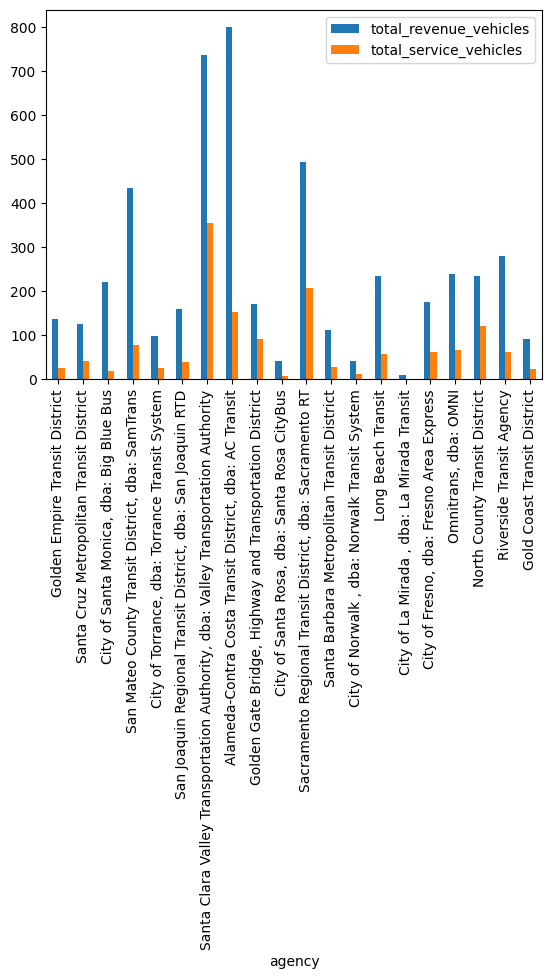

In [37]:
# Total revenue vehicles vs total service vehicles
service_v_upt_no_outliers[:20].plot(
    x = "agency",
    y = [
        "total_revenue_vehicles", 
        #"unlinked_passenger_trips",
        "total_service_vehicles"
    ],
    kind = "bar",
    #secondary_y = "total_service_vehicles"  
)

<AxesSubplot:xlabel='agency'>

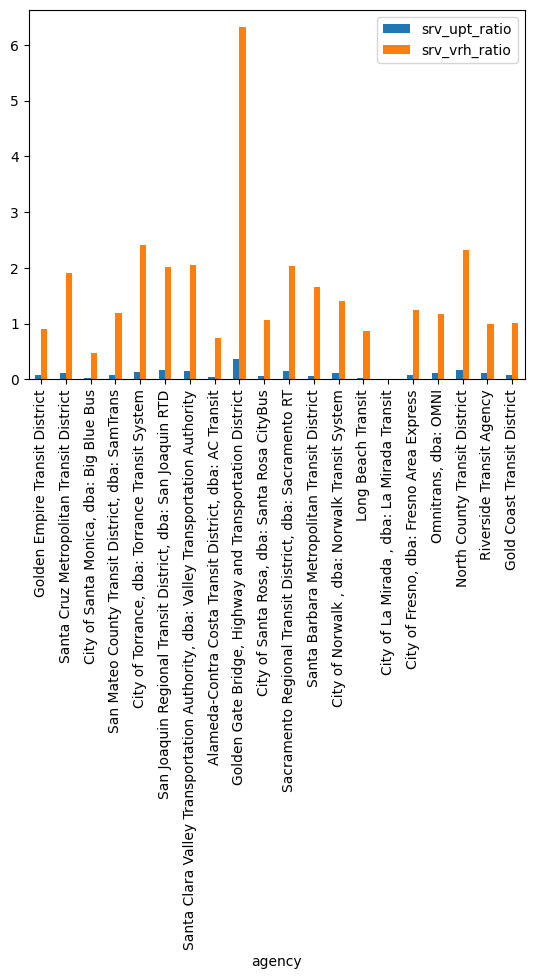

In [38]:
# srv:upt and srv:vrh compare

service_v_upt_no_outliers[:20].plot(
    x = "agency",
    y = [
        "srv_upt_ratio", 
        #"unlinked_passenger_trips",
        "srv_vrh_ratio"
    ],
    kind = "bar",
    #secondary_y = "total_service_vehicles"  
)

In [39]:
service_v_upt_no_outliers.sort_values(by="total_service_vehicles", ascending=False).head()

,ntd_id,agency,city,organization_type,reporter_type,total_revenue_vehicles,total_service_vehicles,unlinked_passenger_trips,vehicle_revenue_hours,_merge,srv_upt_ratio,srv_vrh_ratio
7,90013,"Santa Clara Valley Transportation Authority, dba: Valley Transportation Authority",San Jose,Independent Public Agency or Authority of Transit Service,Full Reporter,737.0,356.0,23853939.0,1733169.0,both,0.149242,2.054041
12,90019,"Sacramento Regional Transit District, dba: Sacramento RT",Sacramento,Independent Public Agency or Authority of Transit Service,Full Reporter,494.0,207.0,14349668.0,1019416.0,both,0.144254,2.030574
54,90151,"Southern California Regional Rail Authority, dba: Metrolink",Los Angeles,Independent Public Agency or Authority of Transit Service,Full Reporter,275.0,197.0,3703404.0,306389.0,both,0.531943,6.429735
8,90014,"Alameda-Contra Costa Transit District, dba: AC Transit",Oakland,Independent Public Agency or Authority of Transit Service,Full Reporter,799.0,154.0,35190057.0,2047682.0,both,0.043762,0.752070
23,90036,Orange County Transportation Authority,Orange,Independent Public Agency or Authority of Transit Service,Full Reporter,1105.0,144.0,32674688.0,2076903.0,both,0.044071,0.693340


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Service Vehicle to VRH Ratio')

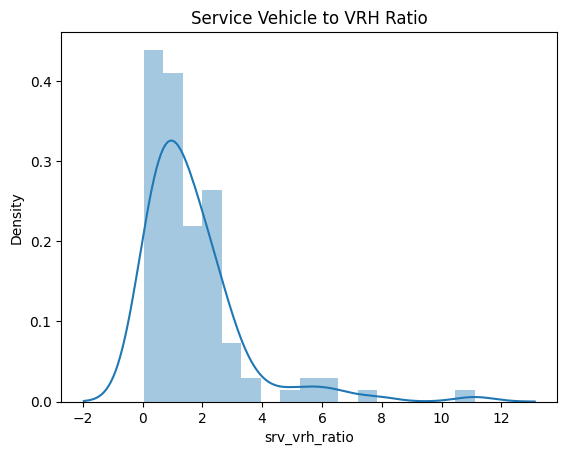

In [40]:
sns.distplot(service_v_upt_no_outliers[service_v_upt_no_outliers["srv_vrh_ratio"]>0]["srv_vrh_ratio"]).set_title('Service Vehicle to VRH Ratio')

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Service Vehicle to UPT Ratio')

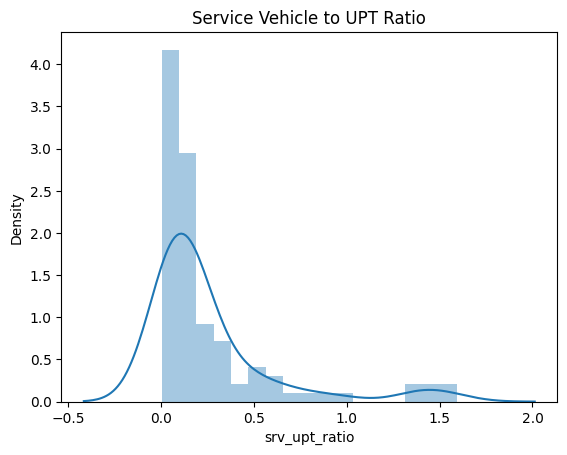

In [41]:
sns.distplot(service_v_upt_no_outliers[service_v_upt_no_outliers["srv_upt_ratio"]>0]["srv_upt_ratio"]).set_title("Service Vehicle to UPT Ratio")

In [42]:
def make_scatter(
    data,
    x_ax,
    y_ax
):
    chart = alt.Chart(data).mark_point().encode(
    x = x_ax,
    y = y_ax,
    tooltip=[x_ax,y_ax],
    ).properties(title=f"{x_ax} vs. {y_ax}").interactive()

    return chart + chart.transform_regression(x_ax,y_ax).mark_line()

In [43]:
make_scatter(service_v_upt_no_outliers[service_v_upt_no_outliers["total_service_vehicles"]>0],"total_service_vehicles","unlinked_passenger_trips")

alt.LayerChart(...)

In [44]:
make_scatter(service_v_upt_no_outliers[service_v_upt_no_outliers["total_service_vehicles"]>0],"total_service_vehicles","vehicle_revenue_hours")

alt.LayerChart(...)

In [45]:
make_scatter(service_v_upt_no_outliers[service_v_upt_no_outliers["total_service_vehicles"]>0],"total_service_vehicles","total_revenue_vehicles")

alt.LayerChart(...)